In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler


In [2]:
df_wine = pd.read_csv("data/wine-reviews.csv", usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])
df_wine.head()


,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [3]:
df_diabetes = pd.read_csv("data/diabetes.csv")
df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# WINE

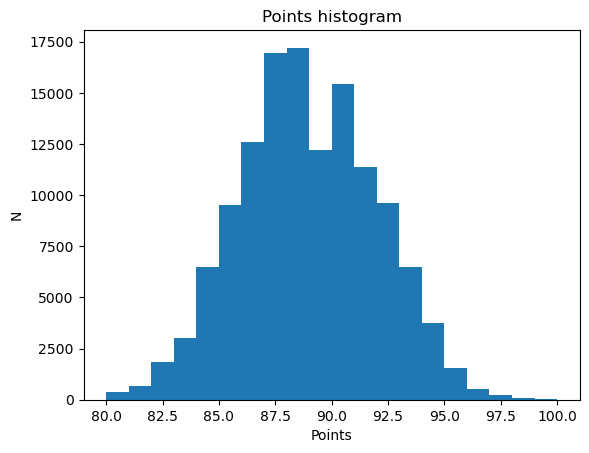

In [4]:
plt.hist(df_wine.points, bins=20)
plt.title("Points histogram")
plt.xlabel("Points")
plt.ylabel("N")
plt.show()

In [5]:
df_wine["label"] = (df_wine.points >= 90).astype(int)
df_wine = df_wine[["description", "label"]]
df_wine.tail()

,description,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1
129970,"Big, rich and off-dry, this is powered by inte...",1


In [6]:
train, valid, test = np.split(df_wine.sample(frac=1), [int(0.8*len(df_wine)), int(0.9*len(df_wine))])

In [7]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('label')
    df = df["description"]
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds
    

In [46]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(valid)
test_data = df_to_dataset(test)

print(train)
print(train_data)

                                             description  label
58560  Bramble, leather and red fruit make for a dece...      0
20061  This is technically a white wine but with eyes...      1
9459   Additions of Sauvignon Musque and Sauvignon Gr...      1
13178  Oak, chocolate, vanilla and ripe black plum wa...      0
13383  Mouthwatering aromas of tropical mango, melon ...      1
...                                                  ...    ...
71396  Still the best wine in the lineup, this Bordea...      1
80275  Aromas of golden raisins, fig, licorice and va...      0
66359  This certified organic and biodynamic wine has...      0
37214  Underbrush, scorched earth, dried tobacco leaf...      0
91903  Made of 70% Sangiovese, 20% Ciliegiolo and 10%...      0

[103976 rows x 2 columns]
<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [47]:
list(train_data)[0]

(<tf.Tensor: shape=(32,), dtype=string, numpy=
 array([b'A structured wine, this is packed with tannins as well as dark fruit and flavors from the wood aging. It is solid, backed with a concentrated, dry aftertaste with great potential. Drink from 2018.',
        b'Elegant aromas of blackcurrant and black cassis combine with German-chocolate cake and concentrated violet oil scents on the nose of this bottling. It is soft and full on the palate, where mouth-coating tannins present flavors of earthy loam, black cherry and hint of burnt caramel on the finish.',
        b'Chiseled aromas of lemon-lime and spring flowers are lean but clean, and that pretty much describes this blend of Treixadura, Torront\xc3\xa9s and Palomino. Lime and green banana are the key flavors, and the finish brings back lemon-lime and minerality. More basic than flashy, but nice in a neutral way.',
        b'Lively, crisp wine from an estate founded by the Knights Templar in the 13th century. It is full of deliciou

In [12]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)
# if this doesn't work:
# delete the folder which it says has missing files


In [48]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(32, 50), dtype=float32, numpy=
array([[ 0.6689758 ,  0.16576575, -0.13521467, ...,  0.13946126,
         0.13851921,  0.16855039],
       [ 0.3200059 ,  0.11339432,  0.00902018, ..., -0.05253916,
        -0.10325631,  0.28757682],
       [ 0.29409456,  0.01803284,  0.14000809, ...,  0.14291401,
        -0.09585661,  0.07713935],
       ...,
       [ 0.31363404, -0.09501137,  0.07085366, ..., -0.02226255,
         0.07415194,  0.19731054],
       [ 0.39786163, -0.17449933, -0.04776595, ..., -0.02454607,
         0.09373444,  0.09938257],
       [ 0.22535513, -0.19957462, -0.07883631, ...,  0.22048974,
         0.24652386,  0.18409798]], dtype=float32)>

In [14]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [15]:
import os

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 256

n_batches = 10

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*n_batches)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [17]:
model.evaluate(train_data)

3250/3250 [==============================] - 3s 793us/step - loss: 0.6983 - accuracy: 0.4512


[0.6982524991035461, 0.45119065046310425]

In [18]:
model.evaluate(valid_data)

407/407 [==============================] - 0s 791us/step - loss: 0.6983 - accuracy: 0.4543


[0.6982635855674744, 0.45425868034362793]

In [19]:
history = model.fit(train_data, epochs=10, validation_data=valid_data, callbacks=[cp_callback])

Epoch 1/2
  49/3250 [..............................] - ETA: 13:08 - loss: 0.6792 - accuracy: 0.5791
Epoch 1: saving model to training_2\cp-0001.ckpt
  99/3250 [..............................] - ETA: 13:17 - loss: 0.6718 - accuracy: 0.5966
Epoch 1: saving model to training_2\cp-0001.ckpt
 149/3250 [>.............................] - ETA: 13:07 - loss: 0.6662 - accuracy: 0.6061
Epoch 1: saving model to training_2\cp-0001.ckpt
 199/3250 [>.............................] - ETA: 12:59 - loss: 0.6567 - accuracy: 0.6162
Epoch 1: saving model to training_2\cp-0001.ckpt
 249/3250 [=>............................] - ETA: 12:49 - loss: 0.6456 - accuracy: 0.6261
Epoch 1: saving model to training_2\cp-0001.ckpt
 299/3250 [=>............................] - ETA: 12:41 - loss: 0.6362 - accuracy: 0.6344
Epoch 1: saving model to training_2\cp-0001.ckpt
 349/3250 [==>...........................] - ETA: 12:32 - loss: 0.6260 - accuracy: 0.6445
Epoch 1: saving model to training_2\cp-0001.ckpt
 399/3250 [==>...

In [20]:
model.evaluate(test_data)

 55/407 [===>..........................] - ETA: 0s - loss: 0.3734 - accuracy: 0.8352

407/407 [==============================] - 0s 951us/step - loss: 0.3781 - accuracy: 0.8301


[0.37813234329223633, 0.8300507664680481]

In [30]:
# save model in file to load at a later date
# model.save("model2.h5")
# model.save_weights("model2_weights")

# load model from file
latest = tf.train.latest_checkpoint(checkpoint_dir="training_2")
model2 = tf.keras.Sequential()
model2.add(hub_layer)
model2.add(tf.keras.layers.Dense(16, activation="relu"))
model2.add(tf.keras.layers.Dropout(0.4))
model2.add(tf.keras.layers.Dense(16, activation="relu"))
model2.add(tf.keras.layers.Dropout(0.4))
model2.add(tf.keras.layers.Dense(1, activation="sigmoid")) 
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
model2.load_weights(latest)
model2.evaluate(test_data)

407/407 [==============================] - 1s 882us/step - loss: 0.3781 - accuracy: 0.8301


[0.3781324625015259, 0.8300507664680481]

In [33]:
print(history.history)

{'loss': [0.46515822410583496, 0.3686065375804901], 'accuracy': [0.7740920782089233, 0.8355004787445068], 'val_loss': [0.3801964819431305, 0.3726419508457184], 'val_accuracy': [0.8248826861381531, 0.8310379385948181]}


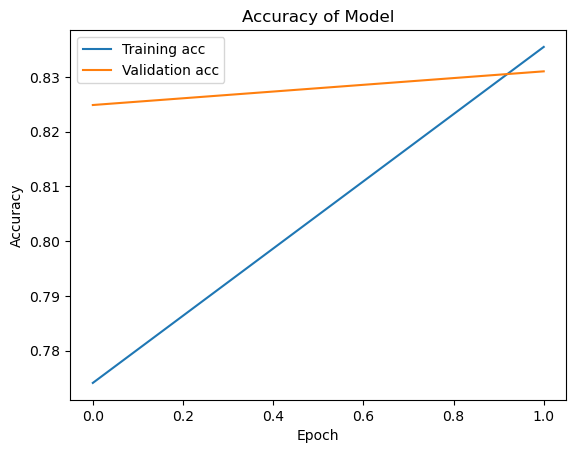

In [34]:
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.title("Accuracy of Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

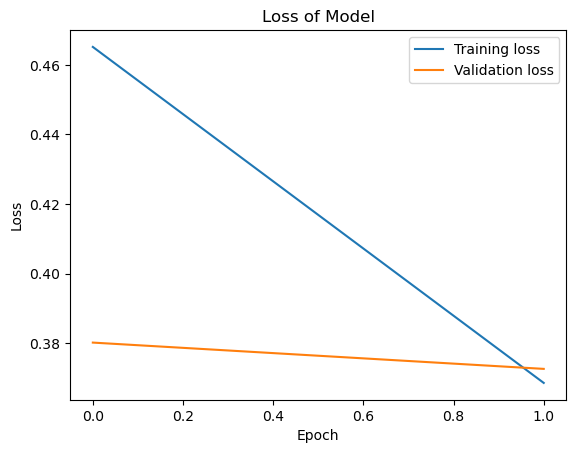

In [37]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title("Loss of Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# LSTM


In [49]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [58]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [59]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True,
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

In [60]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [64]:
model.evaluate(train_data)
model.evaluate(valid_data)

407/407 [==============================] - 2s 5ms/step - loss: 0.6931 - accuracy: 0.5050


[0.6931473612785339, 0.504962682723999]

In [65]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
3250/3250 [==============================] - 40s 12ms/step - loss: 0.3978 - accuracy: 0.8171 - val_loss: 0.3648 - val_accuracy: 0.8355
Epoch 2/5
3250/3250 [==============================] - 38s 12ms/step - loss: 0.3542 - accuracy: 0.8406 - val_loss: 0.3450 - val_accuracy: 0.8444
Epoch 3/5
3250/3250 [==============================] - 38s 12ms/step - loss: 0.3417 - accuracy: 0.8454 - val_loss: 0.3433 - val_accuracy: 0.8454
Epoch 4/5
3250/3250 [==============================] - 38s 12ms/step - loss: 0.3311 - accuracy: 0.8497 - val_loss: 0.3497 - val_accuracy: 0.8426
Epoch 5/5
3250/3250 [==============================] - 38s 12ms/step - loss: 0.3220 - accuracy: 0.8522 - val_loss: 0.3594 - val_accuracy: 0.8378


In [66]:
model.evaluate(test_data)

407/407 [==============================] - 2s 4ms/step - loss: 0.3627 - accuracy: 0.8341


[0.36270177364349365, 0.8340513706207275]

# DIABETES

In [ ]:
for i in range(len(df_diabetes[:-1])):
    label = df_diabetes.columns[i]
    plt.hist(df_diabetes[df_diabetes['Outcome']==1][label], color='red', label='Diabetes', alpha=0.7, density=True, bins=15)
    plt.hist(df_diabetes[df_diabetes['Outcome']==0][label], color='green', label='No Diabetes', alpha=0.7, density=True, bins=15)
    plt.title(label)
    plt.xlabel(label)
    plt.ylabel('N')
    plt.legend()
    plt.show()

In [ ]:
X = df_diabetes[df_diabetes.columns[:-1]].values
y = df_diabetes[df_diabetes.columns[-1]].values

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
data = np.hstack((X, np.reshape(y, (-1, 1))))
transformed_df = pd.DataFrame(data, columns=df_diabetes.columns)

In [ ]:
len(transformed_df[transformed_df['Outcome']==1]), len(transformed_df[transformed_df['Outcome']==0])

(268, 500)

In [ ]:
over = RandomOverSampler()
X, y = over.fit_resample(X, y)
data = np.hstack((X, np.reshape(y, (-1, 1))))
transformed_df = pd.DataFrame(data, columns=df_diabetes.columns)


In [ ]:
len(transformed_df[transformed_df['Outcome']==1]), len(transformed_df[transformed_df['Outcome']==0])

(500, 500)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adagrad(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(X_train, y_train)

19/19 [==============================] - 0s 999us/step - loss: 0.7495 - accuracy: 0.3883


[0.7494762539863586, 0.3883333206176758]

In [ ]:
model.evaluate(X_valid, y_valid)

16/16 [==============================] - 0s 604us/step - loss: 0.7478 - accuracy: 0.4020


[0.7477594017982483, 0.4020000100135803]

In [ ]:
model.fit(X_train, y_train, batch_size=16, epochs=32, validation_data=(X_valid, y_valid))

Epoch 1/32
38/38 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6583 - val_loss: 0.6464 - val_accuracy: 0.6680
Epoch 2/32
38/38 [==============================] - 0s 1ms/step - loss: 0.6470 - accuracy: 0.6583 - val_loss: 0.6451 - val_accuracy: 0.6680
Epoch 3/32
38/38 [==============================] - 0s 2ms/step - loss: 0.6457 - accuracy: 0.6600 - val_loss: 0.6438 - val_accuracy: 0.6760
Epoch 4/32
38/38 [==============================] - 0s 1ms/step - loss: 0.6444 - accuracy: 0.6667 - val_loss: 0.6425 - val_accuracy: 0.6740
Epoch 5/32
38/38 [==============================] - 0s 1ms/step - loss: 0.6431 - accuracy: 0.6667 - val_loss: 0.6413 - val_accuracy: 0.6760
Epoch 6/32
38/38 [==============================] - 0s 2ms/step - loss: 0.6418 - accuracy: 0.6667 - val_loss: 0.6401 - val_accuracy: 0.6780
Epoch 7/32
38/38 [==============================] - 0s 2ms/step - loss: 0.6406 - accuracy: 0.6683 - val_loss: 0.6389 - val_accuracy: 0.6800
Epoch 8/32
38/38 [==

In [ ]:
model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 733us/step - loss: 0.6376 - accuracy: 0.6360


[0.6375736594200134, 0.6359999775886536]